In [124]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)

from models import DeepConditionalModel, ConditionalVAE, HeteroscedasticModel
from inn_utils import train_online_ml, compute_metrics, train_online_kl, train_online_heteroscedastic
from process_models import simulate_ricker
from viz import plot_true_est_scatter, plot_true_est_posterior, plot_losses, plot_sbc, plot_metrics, plot_variance

In [2]:
tf.enable_eager_execution()

In [3]:
%load_ext autoreload
%autoreload 2

# Conditional Invertible Neural Network (cINN)

## Summary network for the Ricker model
<p>We use an LSTM for the observed time-series data.</p>

In [9]:
class SequenceNetwork(tf.keras.Model):
    """
    Implements an LSTM summary network to summarize time-series data generated from the Ricker model.
    """
    
    def __init__(self, h_lstm_dim=32, h_dense_dim=64):
        super(SequenceNetwork, self).__init__()
        
        self.summary_part = tf.keras.Sequential([
            tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(h_lstm_dim)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
        ])
    
    def call(self, x, training=True):
        
        x = self.summary_part(x, training=training)
        return x

<p>We will also append a dummy noise parameter to the true parameter vector.</p>

In [5]:
def add_noise_var(X_batch, theta_batch):
    """
    Adds a column of uniform noise to the true parameter values.
    """
    
    noise_col = tf.random_uniform(shape=(theta_batch.shape[0], 1))
    theta_batch = tf.concat((theta_batch, noise_col), axis=-1)
    return X_batch, theta_batch

## Initialization 

In [6]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
train = False
param_names = [r'$r$', r'$\sigma$', r'$\rho$', r'u']
theta_dim = 4
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 64
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 10
n_test = 300
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 2000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)

In [7]:
param_names = [r'$r$', r'$\sigma$', r'$\rho$', r'u']

### Create test data

In [8]:
# For scatter
X_test, theta_test = simulate_ricker(n_test, t_obs_min=500, t_obs_max=500)
X_test, theta_test = add_noise_var(X_test, theta_test)

In [9]:
# For full posteriors
X_test2, theta_test2 = simulate_ricker(n_test2, t_obs_min=500, t_obs_max=500)
X_test2, theta_test2 = add_noise_var(X_test2, theta_test2)

### Create networks

In [10]:
summary_net = SequenceNetwork(h_lstm_dim=summary_dim)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

### Checkpoint manager

In [11]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/ricker', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/ricker\ckpt-final


### Plot performance of untrained networks

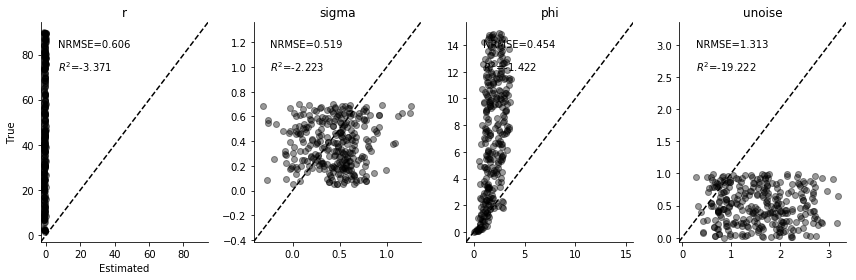

In [32]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(12, 4))

## Train the model

In [87]:
%%time
if train:
    for ep in range(1, epochs+1):
        with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
            losses = train_loop_active(model, optimizer, simulate_ricker, iterations_per_epoch, 
                                batch_size, iterations_per_epoch, p_bar, clip_value=clip_value, 
                                global_step=global_step, transform=add_noise_var, 
                                ckpt_name='Ricker_{}'.format(ep))

            # Store checkpoint
            manager.save()

## Evaluate the trained model

### Posterior means (recovery)

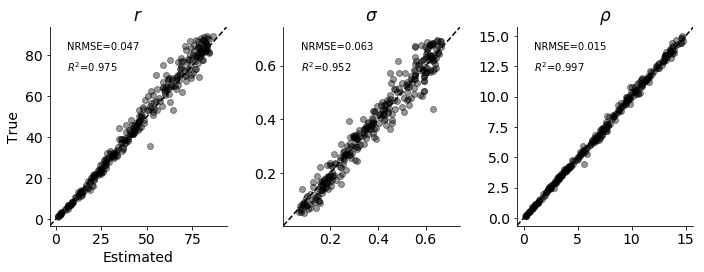

In [55]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, 
                      param_names[:3], figsize=(10, 4), filename='Ricker')

### Full posterior (visual inspection)

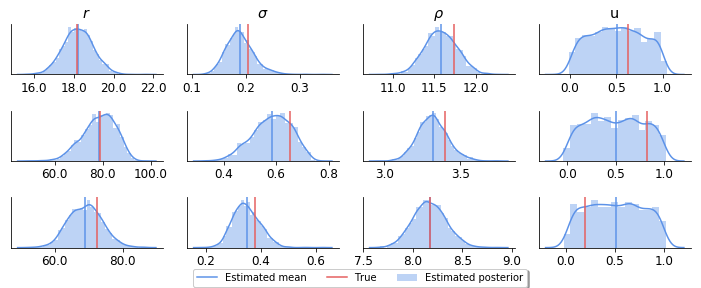

In [12]:
plot_true_est_posterior(model, n_samples=n_samples_posterior, param_names=param_names, 
                        X_test=X_test2, theta_test=theta_test2, tight=True, figsize=(10, 4), filename='Ricker')

### Simulation-based calibration

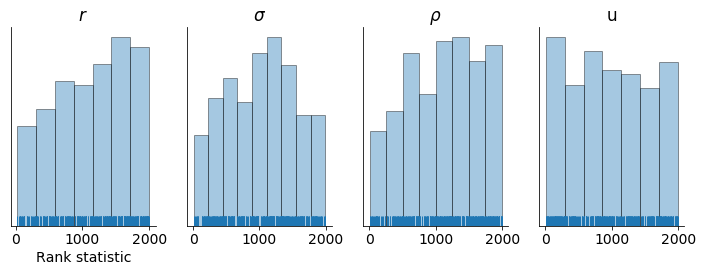

In [59]:
plot_sbc(model, n_samples_posterior, X_test, theta_test, param_names, figsize=(10, 4), filename='Ricker')

### Compute metrics for all t_obs

In [24]:
n_min=100
n_max=500
with tqdm(total=n_max-n_min, desc='Computation of metrics') as p_bar:
    ns, metrics = compute_metrics(model, param_names, simulate_ricker, n_test, 
                                  n_samples_posterior, p_bar=p_bar, transform=add_noise_var, 
                                  n_min=n_min, n_max=n_max)

#### Plot metrics

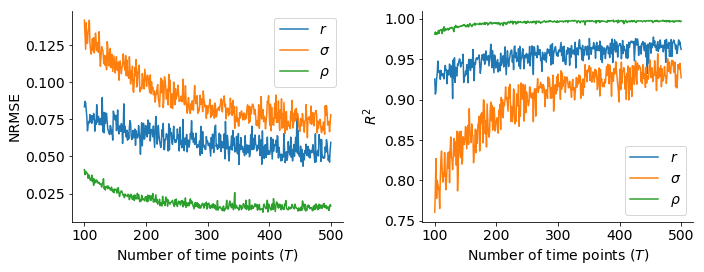

In [92]:
plot_metrics(metrics, ns, param_names[:3], figsize=(10, 4), xlabel=r'Number of time points ($T$)', filename='Ricker')

#### Plot variance

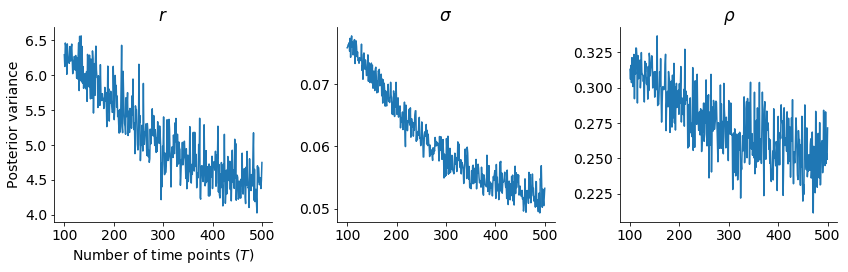

In [70]:
plot_variance(metrics['var'], ns, param_names[:3], figsize=(12, 4), xlabel=r'Number of time points ($T$)', filename='Ricker')

#### Speed of inference

In [12]:
n_speed = 1000
X_test3, theta_test3 = simulate_ricker(n_speed, t_obs_min=500, t_obs_max=500)
X_test3, theta_test3 = add_noise_var(X_test3, theta_test)

In [16]:
%timeit model.sample(X_test3, n_samples_posterior)

5.96 s ± 52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Conditional Variational Autoencoder (cVAE)

## Initialization

### Training hyperparameters

In [50]:
# --- Structure of the VAE --- #
vae_meta = {
    'n_units': [128, 128, 128, 128],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
param_names = [r'$r$', r'$\sigma$', r'$\rho$']
theta_dim = 3
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 64
z_dim = 12
beta = tfe.Variable(0.0, dtype=tf.float32)
beta_step = 250
beta_increment = 0.01
epochs = 100
iterations_per_epoch = 1000
n_test = 300
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 1000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)

### Create test data

In [62]:
# For scatter
X_test, theta_test = simulate_ricker(n_test, t_obs_min=500, t_obs_max=500)

In [79]:
# For full posteriors
X_test2, theta_test2 = simulate_ricker(n_test2, t_obs_min=500, t_obs_max=500)

### Create networks

In [64]:
summary_net = SequenceNetwork(h_lstm_dim=summary_dim)
vae = ConditionalVAE(vae_meta, theta_dim, z_dim, summary_net)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

### Create checkpoints

In [65]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=vae)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/ricker_vae', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


### Plot performance of untrained networks

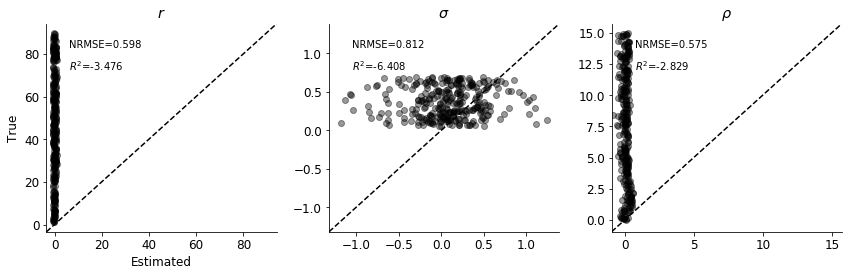

In [66]:
plot_true_est_scatter(vae, X_test, theta_test, n_samples_posterior, param_names, figsize=(12, 4))

## Train the model

In [89]:
%%time

for ep in range(1, 30+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        
        losses = train_online_kl(vae, optimizer, simulate_ricker, iterations_per_epoch, 
                            batch_size, beta, p_bar, clip_value=clip_value, 
                            global_step=global_step, beta_step=beta_step, beta_increment=beta_increment)
        
        # Plot stuff
        plot_true_est_scatter(vae, X_test, theta_test, n_samples_posterior, param_names, figsize=(8, 3))

        # Store checkpoint
        manager.save()

## Evaluate the trained model

## Posterior means (recovery)

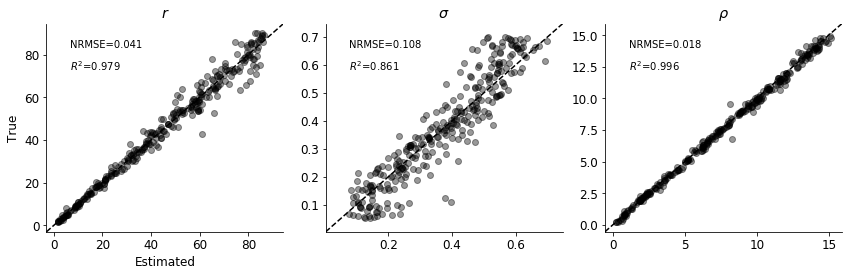

In [100]:
plot_true_est_scatter(vae, X_test, theta_test, n_samples_posterior, param_names, figsize=(12, 4))

### Full posterior (visual)

In [ ]:
plot_true_est_posterior(vae, n_samples=5000, param_names=param_names, 
                        X_test=X_test2, theta_test=theta_test2, tight=True, figsize=(10, 4))

### Simulation-based calibration

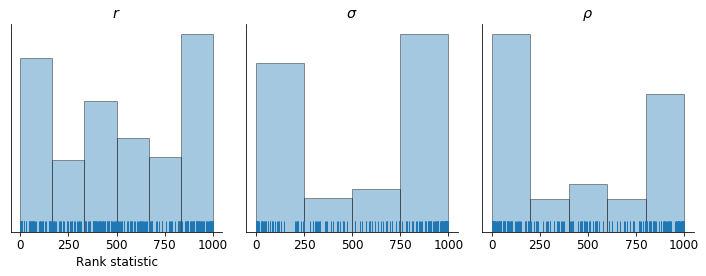

In [101]:
plot_sbc(vae, n_samples_posterior, X_test, theta_test, param_names, figsize=(10, 4))

# DeepInference (heteroscedastic loss)

## Initialization

### Training hyperparameters

In [120]:
# --- Structure of the VAE --- #
model_meta = {
    'n_units': [128, 128, 128, 128],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
param_names = [r'$r$', r'$\sigma$', r'$\rho$']
theta_dim = 3
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 64
epochs = 100
iterations_per_epoch = 1000
n_test = 300
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 1000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)

### Create test data

In [125]:
# For scatter
X_test, theta_test = simulate_ricker(n_test, t_obs_min=500, t_obs_max=500)

In [126]:
# For full posteriors
X_test2, theta_test2 = simulate_ricker(n_test2, t_obs_min=500, t_obs_max=500)

### Create networks

In [127]:
summary_net = SequenceNetwork(h_lstm_dim=summary_dim)
model = HeteroscedasticModel(model_meta, theta_dim, summary_net)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

### Create checkpoints

In [128]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/ricker_deep_inference', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


### Plot performance of untrained networks

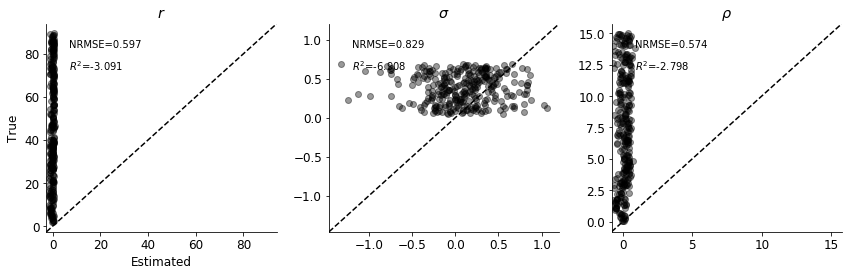

In [129]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(12, 4))

## Train the model

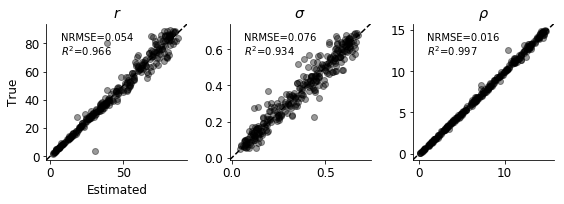

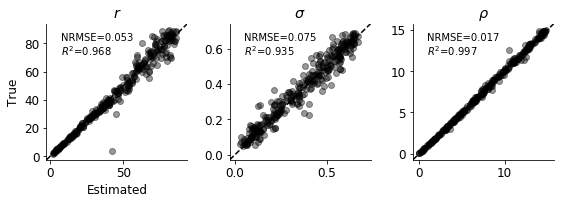

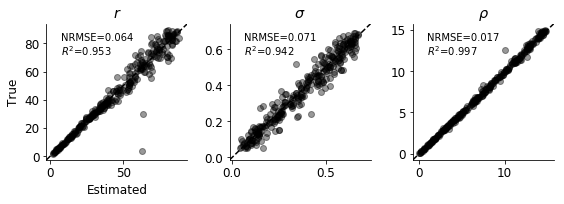

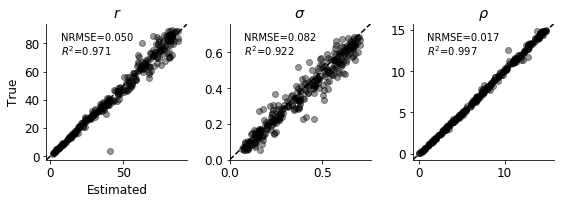

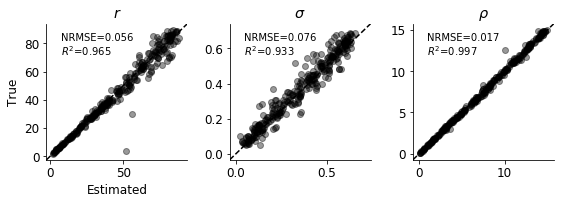

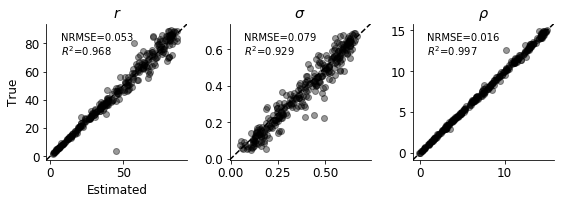

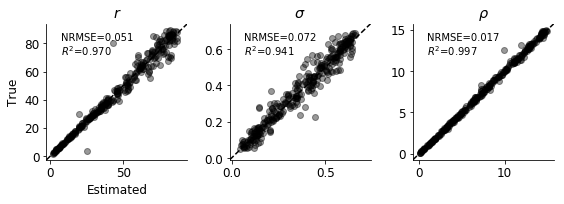

In [ ]:
%%time
for ep in range(1, 20+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        
        losses = train_online_heteroscedastic(model, optimizer, simulate_ricker, iterations_per_epoch, 
                            batch_size, p_bar, clip_value=clip_value, global_step=global_step)
        
        # Plot stuff
        plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(8, 3))

        # Store checkpoint
        manager.save()

## Evaluate the trained model

### Posterior means (recovery)

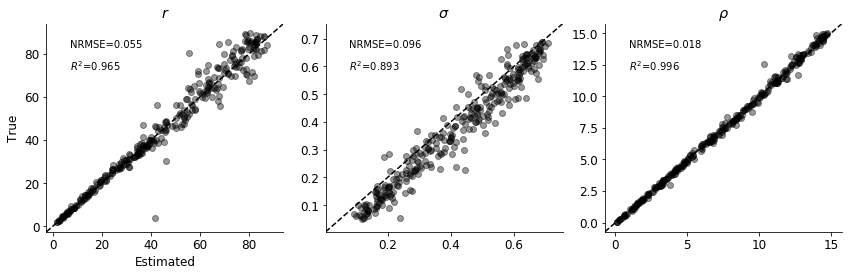

In [131]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(12, 4))

### Full posteriors (visual)

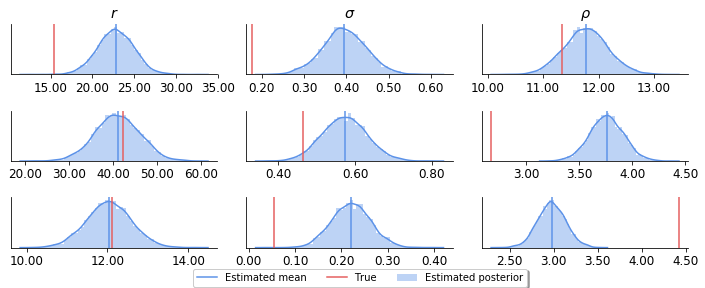

In [132]:
plot_true_est_posterior(model, n_samples=5000, param_names=param_names, 
                        X_test=X_test2, theta_test=theta_test2, tight=True, figsize=(10, 4))

### Simulation-based calibration

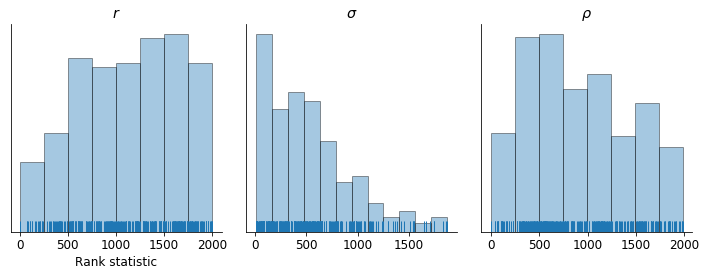

In [133]:
plot_sbc(model, n_samples_posterior, X_test, theta_test, param_names, figsize=(10, 4))